In [43]:
import numpy as np
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
from pyomo.environ import Constraint
import logging


In [44]:
%matplotlib inline
logging.basicConfig(level="INFO")

## Δεδομένα Παραγωγής και Κατανάλωσης

In [45]:
data=pd.read_csv("time_series_60min_singleindex.csv", parse_dates=True)
data.set_index(['utc_timestamp'], inplace=True)
gr_cols = [col for col in data.columns if col.startswith('GR_')]
data=data[gr_cols]
data=data['2015-01-01':'2020-09-30']
data=data.fillna(method='pad')
data=data.fillna(method='backfill')
data_load=data['GR_load_actual_entsoe_transparency']/2000 #Υποθετω οτι ειναι για 10.000.000/2.000 = 5.000 άτομα
data_pvprod=data['GR_solar_generation_actual']/(2115/5)  
data_pvprod.describe()

count    50376.000000
mean         0.991647
std          1.361433
min          0.000000
25%          0.000000
50%          0.037825
75%          1.964539
max          5.000000
Name: GR_solar_generation_actual, dtype: float64

In [46]:
data_load.describe()

count    50376.000000
mean         2.910121
std          0.564945
min          1.504880
25%          2.480803
50%          2.884853
75%          3.297722
max          4.874310
Name: GR_load_actual_entsoe_transparency, dtype: float64

## Προσομοίωση Δικτύου

In [47]:
network = pypsa.Network()
network.set_snapshots(data.index)

In [48]:
#Add buses and carriers to the network
network.add("Bus", "Diesel", carrier='AC')
network.add("Carrier", "diesel")  #diesel=1.27 tonnes/MWh 

network.add("Bus", "Solar", carrier="AC")
network.add("Carrier", "solar")

#Add lines
network.add("Line","Line",bus0="Diesel",bus1="Solar",r=0.01,x=0.1, s_nom_extendable=True)

#Add generators
network.add(
    "Generator",
    "Diesel Gen",
    bus="Diesel",
    carrier="diesel",
    p_nom=5, #MW
    p_nom_extendable=False,
    p_min_pu=0.3,
    control="Slack",
    capital_cost=0, #Capital cost of extending p_nom by 1 MW (€/MW)
    marginal_cost=305, #diesel:0.2€/kWh, CO2 emissions: 80-85€/tCO2*1.27 tonnes/MWh = 105€/MWh (€/MWh)
    )

network.add(
    "Generator",
    "PV Park",
    bus="Solar",
    carrier="solar",
    control="PV", 
    p_nom=1, #MW 
    p_nom_extendable=False,
    p_max_pu=np.array(data_pvprod),
    capital_cost=0, #Capital cost of extending p_nom by 1 MW (€/MW)
    marginal_cost=24 # 20-60€/MWh
    )

#Add loads
network.add("Load", "load 1", bus="Solar", p_set=np.array((data_load))) 

## Ροή φορτίου και Βελτιστοποίηση
Χρησιμοποείται η εντολή network.optimize() για να τρέξει το σύστημα και να βελτιστοποιηθεί το αποτέλεσμα. Ο χρόνος εκτέλεσης ειναι 20sec.

In [49]:
network.optimize(network.snapshots, solver_name="glpk", solver_options={})

<__array_function__ internals>:200: RuntimeWarning:

invalid value encountered in cast

INFO:linopy.model: Solve linear problem using Glpk solver
INFO:linopy.io:Writing objective.
Writing variables.: 100%|██████████| 3/3 [00:00<00:00,  6.70it/s]
INFO:linopy.io: Writing time: 4.04s


GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --lp C:\Users\2F06~1\AppData\Local\Temp\linopy-problem-n6si8hi5.lp --output
 C:\Users\2F06~1\AppData\Local\Temp\linopy-solve-2aqjrpwc.sol
Reading problem data from 'C:\Users\2F06~1\AppData\Local\Temp\linopy-problem-n6si8hi5.lp'...
403009 rows, 151129 columns, 604513 non-zeros
2468451 lines were read
GLPK Simplex Optimizer, v4.65
403009 rows, 151129 columns, 604513 non-zeros
Preprocessing...
26 rows, 27 columns, 52 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 26
*     0: obj =   3.597781419e+07 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.6 secs
Memory used: 258.3 Mb (270892492 bytes)
Writing basic solution to 'C:\Users\2F06~1\AppData\Local\Temp\linopy-solve-2aqjrpwc.sol'...


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 151129 primals, 403009 duals
Objective: 3.60e+07
Solver model: not available
Solver message: optimal



('ok', 'optimal')

## Αποτελέσματα και Σχόλια
Παρακάτω εμφανίζονται τα δεδομένα της βελτιστοποίησης οπως είναι: το objective function, το μονογραμμικο διάγραμμα απο το network.iplot() της pypsa και γραφικές παραστάσεις στις οποίες απεικονίζονται η παραγωγή και η ζήτηση.

In [50]:
network.objective

35977814.19

In [51]:
network.iplot()

{'data': [{'x': Diesel   -1.0
   Solar     1.0
   Name: x, dtype: float64,
   'y': Diesel    0.0
   Solar     0.0
   Name: y, dtype: float64,
   'text': Index(['Bus Diesel', 'Bus Solar'], dtype='object', name='Bus'),
   'type': 'scatter',
   'mode': 'markers',
   'hoverinfo': 'text',
   'opacity': 1,
   'marker': {'color': 'cadetblue', 'size': 10}},
  {'x': Line
   Line    0.0
   dtype: float64,
   'y': Line
   Line    0.0
   dtype: float64,
   'text': Index(['Line Line'], dtype='object', name='Line'),
   'type': 'scatter',
   'mode': 'markers',
   'hoverinfo': 'text',
   'marker': {'opacity': 0.0}}],
 'layout': {'title': '',
  'hovermode': 'closest',
  'showlegend': False,
  'shapes': [{'type': 'line',
    'opacity': 0.8,
    'x0': -1.0,
    'y0': 0.0,
    'x1': 1.0,
    'y1': 0.0,
    'line': {'color': 'rosybrown', 'width': 3}}]}}

Η πρωτη γραφικη αφορα το σύστημα για ολόκληρο το διάστημα της προσωμόιωσης (5 χρονια, 9 μηνες), ενώ η δεύτερη για το διάστημα **'2020-07-22':'2020-07-25'**.\
Είναι εμφανές ότι η γεννήτρια λειτουργεί τα βράδια, που δεν υπάρχει ΦΒ παραγωγή, ώστε να καλύψει το φορτίο, ενώ τα μεσημέρια η γεννήτρια λειτουργεί στο 30% ονομαστικής ισχύος για λόγους ευστάθειας και το ΦΒ πάρκο παράγει ενέργεια και η ενέργεια αυτή προτιμάται καθώς το λειτουργικό της κόστος είναι πιο φθηνό.


<Axes: xlabel='snapshot'>

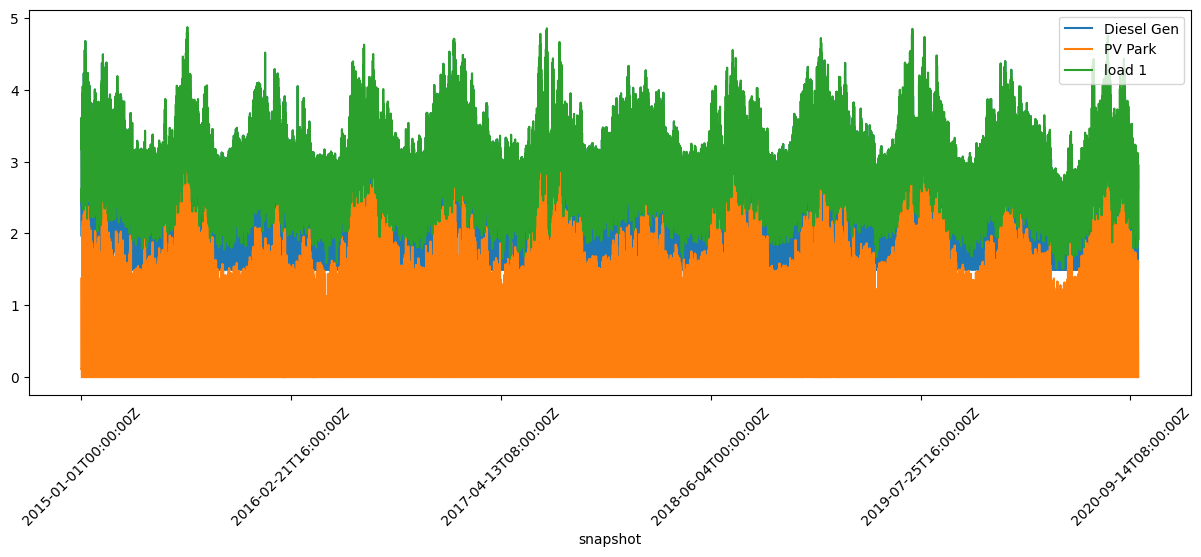

In [52]:
df=pd.concat([network.generators_t.p, network.loads_t.p],axis=1)
df.plot(rot=45)

<Axes: xlabel='snapshot'>

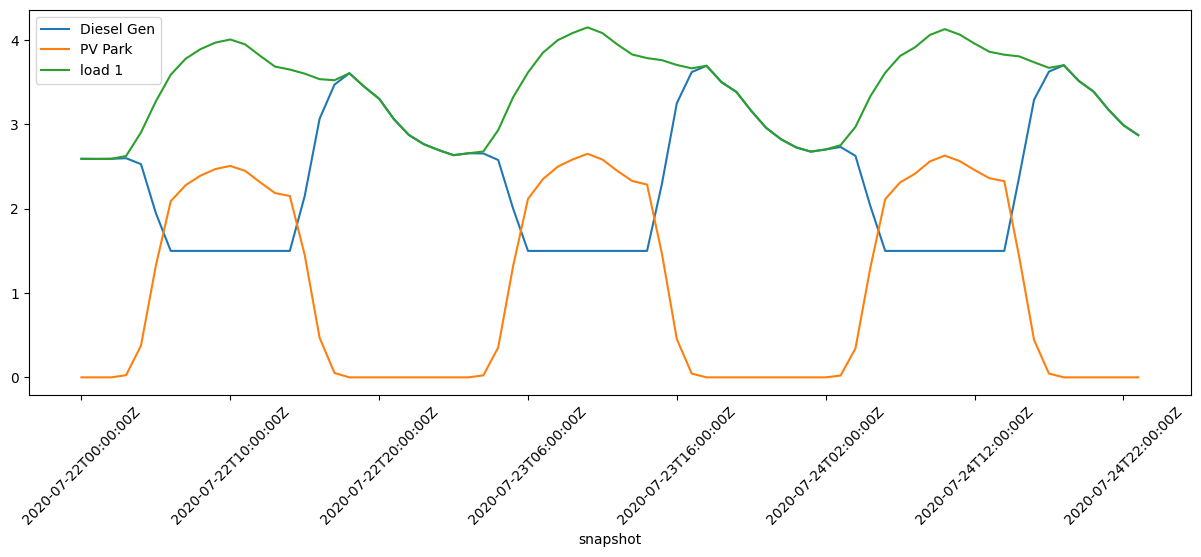

In [53]:
df['2020-07-22':'2020-07-25'].plot(rot=45)